In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math, time, random, datetime

import missingno

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

In [2]:
train = pd.read_csv('train.csv') 
test = pd.read_csv('test.csv')
gender_submission = pd.read_csv('gender_submission.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


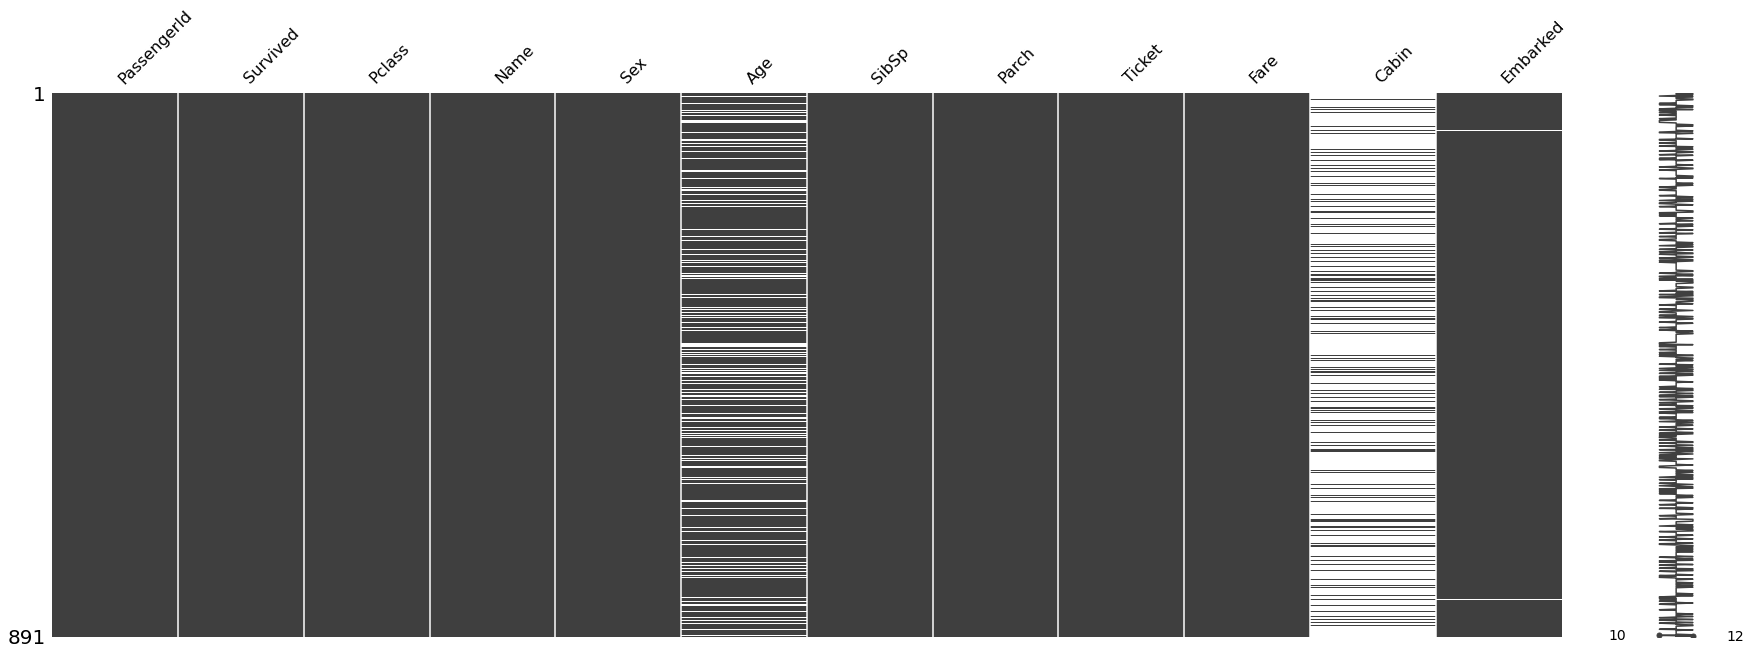

In [7]:
missingno.matrix(train, figsize = (30,10))

In [8]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
print(train.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


In [11]:
def bar_chart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

In [12]:
train_test_data = [train, test] # combining train and test dataset

## Feature engineering

### Pclass

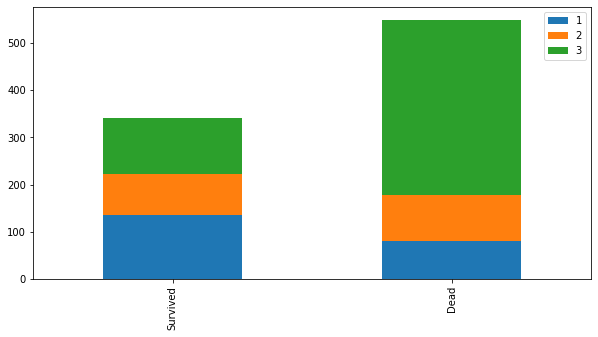

In [13]:
bar_chart('Pclass')

### Sex

In [14]:
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

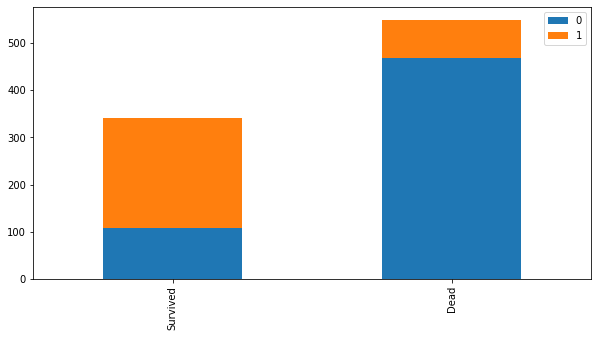

In [15]:
bar_chart('Sex')

### Name

In [16]:
for dataset in train_test_data:
    dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [17]:
title_mapping = {"Mr": 0, "Miss": 1, "Mrs": 2, 
                 "Master": 5, "Dr": 6, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 1,"Countess": 4,
                 "Ms": 2, "Lady": 4, "Jonkheer": 4, "Don": 4, "Dona" : 4, "Mme": 2,"Capt": 3,"Sir": 4 }
"""
Title map:
    0 - Mr
    1 - Miss
    2 - Mrs
    3 - Officer
    4 - Royalty
    5 - Master
    6 - Dr
"""
for dataset in train_test_data:
    dataset['Title'] = dataset['Title'].map(title_mapping)

In [18]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S,0


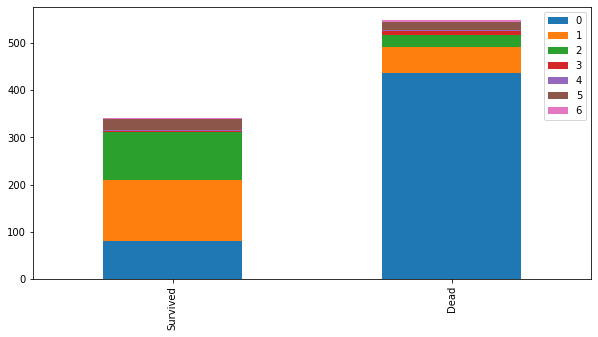

In [19]:
bar_chart('Title')

In [20]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

### SibSp

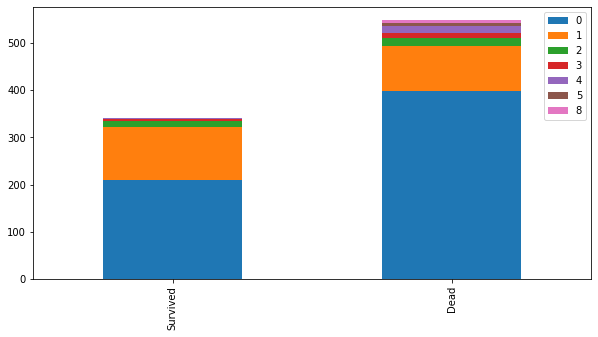

In [21]:
bar_chart('SibSp')

### Parch

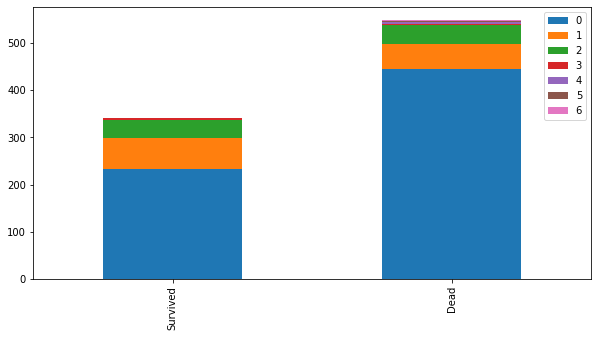

In [22]:
bar_chart('Parch')

### Fare

In [23]:
train["Fare"].fillna(train.groupby("Pclass")["Fare"].transform("median"), inplace=True)
test["Fare"].fillna(test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

In [24]:
for dataset in train_test_data:
    dataset.loc[ dataset['Fare'] <= 17, 'Fare'] = 0,
    dataset.loc[(dataset['Fare'] > 17) & (dataset['Fare'] <= 30), 'Fare'] = 1,
    dataset.loc[(dataset['Fare'] > 30) & (dataset['Fare'] <= 100), 'Fare'] = 2,
    dataset.loc[ dataset['Fare'] > 100, 'Fare'] = 3

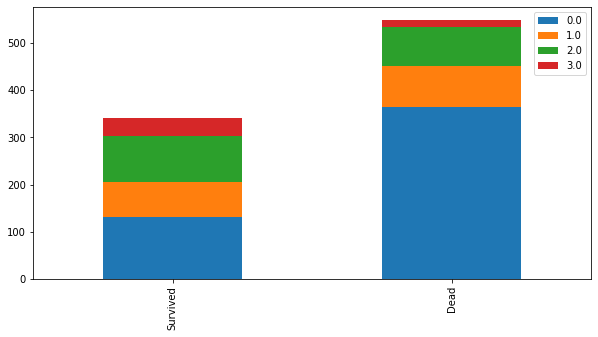

In [25]:
bar_chart('Fare')

In [26]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,0,22.0,1,0,A/5 21171,0.0,NaN,S,0
1,2,1,1,1,38.0,1,0,PC 17599,2.0,C85,C,2
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,0.0,NaN,S,1
3,4,1,1,1,35.0,1,0,113803,2.0,C123,S,2
4,5,0,3,0,35.0,0,0,373450,0.0,NaN,S,0


### Embarked

In [27]:
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

In [28]:
embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

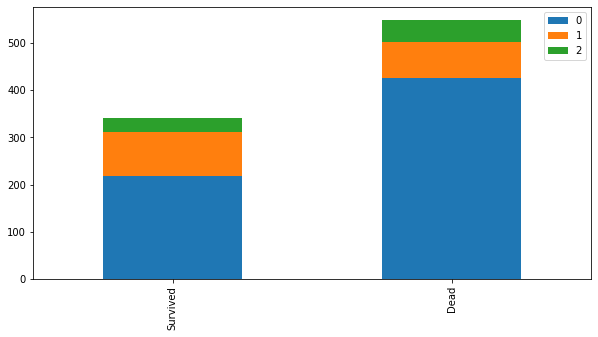

In [29]:
bar_chart('Embarked')

### Age

In [30]:
train["Age"].fillna(train.groupby("Title")["Age"].transform("median"), inplace=True)
test["Age"].fillna(test.groupby("Title")["Age"].transform("median"), inplace=True)

In [31]:
train.head(30)
train.groupby("Title")["Age"].transform("median")

0      30.0
1      35.0
2      21.0
3      35.0
4      30.0
       ... 
886    52.0
887    21.0
888    21.0
889    30.0
890    30.0
Name: Age, Length: 891, dtype: float64

In [32]:
for dataset in train_test_data:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0,
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 26), 'Age'] = 1,
    dataset.loc[(dataset['Age'] > 26) & (dataset['Age'] <= 36), 'Age'] = 2,
    dataset.loc[(dataset['Age'] > 36) & (dataset['Age'] <= 62), 'Age'] = 3,
    dataset.loc[ dataset['Age'] > 62, 'Age'] = 4

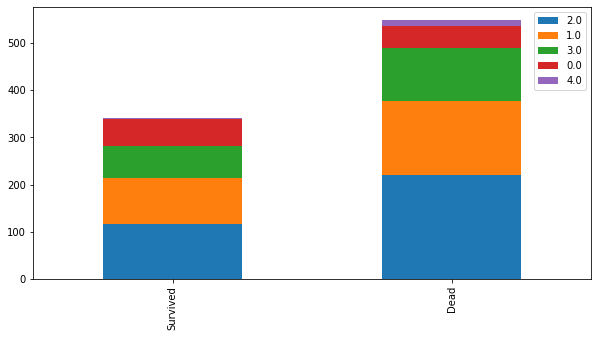

In [33]:
bar_chart('Age')

In [34]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [35]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,0,1.0,1,0,0.0,0,0
1,2,1,1,1,3.0,1,0,2.0,1,2
2,3,1,3,1,1.0,0,0,0.0,0,1
3,4,1,1,1,2.0,1,0,2.0,0,2
4,5,0,3,0,2.0,0,0,0.0,0,0


## Modelling

In [36]:
X_train = train.drop('Survived', axis=1)
y_train = train.Survived

In [37]:
X_train.shape

(891, 9)

In [38]:
def fit_ml_algo(algo, X_train, y_train, cv):
    
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)

    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

### Logistic Regression

In [39]:
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 82.6
Accuracy CV 10-Fold: 82.04
Running Time: 0:00:02.473034


### k-Nearest Neighbours

In [40]:
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 72.28
Accuracy CV 10-Fold: 45.68
Running Time: 0:00:00.070810


### Gaussian Naive Bayes

In [41]:
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 79.01
Accuracy CV 10-Fold: 79.01
Running Time: 0:00:00.026927


### Linear SVC

In [42]:
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 76.21
Accuracy CV 10-Fold: 70.26
Running Time: 0:00:00.135637


### Stochastic Gradient Descent

In [43]:
start_time = time.time()
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), 
                                                  X_train, 
                                                  y_train,
                                                  10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 74.3
Accuracy CV 10-Fold: 55.33
Running Time: 0:00:00.029920


### Decision Tree Classifier

In [44]:
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 100.0
Accuracy CV 10-Fold: 69.92
Running Time: 0:00:00.036902


### Gradient Boosting Trees

In [45]:
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                       X_train, 
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 89.0
Accuracy CV 10-Fold: 79.46
Running Time: 0:00:00.234373


### Catboost

In [46]:
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([0, 1, 2, 4, 5, 7, 8], dtype=int64)

In [47]:
train_pool = Pool(X_train, 
                  y_train,
                  cat_features)

In [48]:
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss')

catboost_model.fit(train_pool,
                   plot=True)

acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009807
0:	learn: 0.6871149	total: 68ms	remaining: 1m 7s
1:	learn: 0.6806435	total: 76.6ms	remaining: 38.2s
2:	learn: 0.6753575	total: 82.9ms	remaining: 27.6s
3:	learn: 0.6698207	total: 101ms	remaining: 25.3s
4:	learn: 0.6647595	total: 103ms	remaining: 20.5s
5:	learn: 0.6597556	total: 108ms	remaining: 17.8s
6:	learn: 0.6541153	total: 125ms	remaining: 17.7s
7:	learn: 0.6488227	total: 134ms	remaining: 16.6s
8:	learn: 0.6443079	total: 145ms	remaining: 16s
9:	learn: 0.6388962	total: 157ms	remaining: 15.5s
10:	learn: 0.6338933	total: 160ms	remaining: 14.4s
11:	learn: 0.6289777	total: 168ms	remaining: 13.8s
12:	learn: 0.6247980	total: 174ms	remaining: 13.2s
13:	learn: 0.6207218	total: 185ms	remaining: 13s
14:	learn: 0.6160581	total: 191ms	remaining: 12.5s
15:	learn: 0.6114924	total: 208ms	remaining: 12.8s
16:	learn: 0.6072206	total: 214ms	remaining: 12.3s
17:	learn: 0.6031887	total: 216ms	remaining: 11.8s
18:	learn: 0.6006584	total: 217ms	remaining: 11.2s
19:	learn: 0.5

161:	learn: 0.4059029	total: 1.48s	remaining: 7.63s
162:	learn: 0.4051972	total: 1.49s	remaining: 7.63s
163:	learn: 0.4048478	total: 1.5s	remaining: 7.67s
164:	learn: 0.4045776	total: 1.52s	remaining: 7.7s
165:	learn: 0.4041383	total: 1.53s	remaining: 7.72s
166:	learn: 0.4036881	total: 1.54s	remaining: 7.69s
167:	learn: 0.4031138	total: 1.55s	remaining: 7.69s
168:	learn: 0.4028773	total: 1.57s	remaining: 7.73s
169:	learn: 0.4024838	total: 1.59s	remaining: 7.75s
170:	learn: 0.4019098	total: 1.6s	remaining: 7.76s
171:	learn: 0.4011016	total: 1.61s	remaining: 7.74s
172:	learn: 0.4007685	total: 1.62s	remaining: 7.76s
173:	learn: 0.4005258	total: 1.63s	remaining: 7.74s
174:	learn: 0.4004142	total: 1.64s	remaining: 7.71s
175:	learn: 0.3999517	total: 1.64s	remaining: 7.67s
176:	learn: 0.3996577	total: 1.65s	remaining: 7.67s
177:	learn: 0.3992201	total: 1.67s	remaining: 7.7s
178:	learn: 0.3988954	total: 1.68s	remaining: 7.71s
179:	learn: 0.3987161	total: 1.69s	remaining: 7.69s
180:	learn: 0.39

322:	learn: 0.3668390	total: 3.37s	remaining: 7.05s
323:	learn: 0.3666704	total: 3.37s	remaining: 7.04s
324:	learn: 0.3666023	total: 3.39s	remaining: 7.04s
325:	learn: 0.3663487	total: 3.4s	remaining: 7.02s
326:	learn: 0.3662823	total: 3.41s	remaining: 7.03s
327:	learn: 0.3660061	total: 3.42s	remaining: 7.01s
328:	learn: 0.3657886	total: 3.43s	remaining: 7s
329:	learn: 0.3656519	total: 3.45s	remaining: 7s
330:	learn: 0.3654602	total: 3.46s	remaining: 7s
331:	learn: 0.3653603	total: 3.48s	remaining: 6.99s
332:	learn: 0.3653586	total: 3.48s	remaining: 6.96s
333:	learn: 0.3652062	total: 3.48s	remaining: 6.95s
334:	learn: 0.3652056	total: 3.49s	remaining: 6.92s
335:	learn: 0.3650919	total: 3.5s	remaining: 6.91s
336:	learn: 0.3648627	total: 3.51s	remaining: 6.91s
337:	learn: 0.3646887	total: 3.52s	remaining: 6.9s
338:	learn: 0.3645369	total: 3.54s	remaining: 6.9s
339:	learn: 0.3643514	total: 3.55s	remaining: 6.9s
340:	learn: 0.3641357	total: 3.57s	remaining: 6.89s
341:	learn: 0.3640452	tota

483:	learn: 0.3465934	total: 5.21s	remaining: 5.55s
484:	learn: 0.3464647	total: 5.22s	remaining: 5.55s
485:	learn: 0.3464036	total: 5.24s	remaining: 5.54s
486:	learn: 0.3463529	total: 5.24s	remaining: 5.52s
487:	learn: 0.3462740	total: 5.26s	remaining: 5.51s
488:	learn: 0.3460684	total: 5.26s	remaining: 5.5s
489:	learn: 0.3459905	total: 5.27s	remaining: 5.49s
490:	learn: 0.3458385	total: 5.29s	remaining: 5.48s
491:	learn: 0.3455616	total: 5.3s	remaining: 5.47s
492:	learn: 0.3454294	total: 5.31s	remaining: 5.46s
493:	learn: 0.3453877	total: 5.33s	remaining: 5.46s
494:	learn: 0.3452269	total: 5.34s	remaining: 5.45s
495:	learn: 0.3450616	total: 5.36s	remaining: 5.44s
496:	learn: 0.3450364	total: 5.37s	remaining: 5.43s
497:	learn: 0.3447657	total: 5.38s	remaining: 5.42s
498:	learn: 0.3445318	total: 5.4s	remaining: 5.42s
499:	learn: 0.3444171	total: 5.42s	remaining: 5.42s
500:	learn: 0.3443682	total: 5.42s	remaining: 5.4s
501:	learn: 0.3442627	total: 5.43s	remaining: 5.39s
502:	learn: 0.34

642:	learn: 0.3296998	total: 6.98s	remaining: 3.88s
643:	learn: 0.3296619	total: 7s	remaining: 3.87s
644:	learn: 0.3296268	total: 7s	remaining: 3.85s
645:	learn: 0.3296195	total: 7.01s	remaining: 3.84s
646:	learn: 0.3295461	total: 7.02s	remaining: 3.83s
647:	learn: 0.3294609	total: 7.03s	remaining: 3.82s
648:	learn: 0.3293071	total: 7.05s	remaining: 3.81s
649:	learn: 0.3291070	total: 7.06s	remaining: 3.8s
650:	learn: 0.3289157	total: 7.08s	remaining: 3.79s
651:	learn: 0.3288402	total: 7.09s	remaining: 3.79s
652:	learn: 0.3287975	total: 7.1s	remaining: 3.77s
653:	learn: 0.3287206	total: 7.12s	remaining: 3.76s
654:	learn: 0.3286561	total: 7.13s	remaining: 3.75s
655:	learn: 0.3285331	total: 7.15s	remaining: 3.75s
656:	learn: 0.3284603	total: 7.16s	remaining: 3.74s
657:	learn: 0.3284004	total: 7.17s	remaining: 3.73s
658:	learn: 0.3283600	total: 7.18s	remaining: 3.71s
659:	learn: 0.3282394	total: 7.19s	remaining: 3.7s
660:	learn: 0.3282251	total: 7.2s	remaining: 3.69s
661:	learn: 0.3280520	

805:	learn: 0.3145453	total: 8.99s	remaining: 2.16s
806:	learn: 0.3144740	total: 9s	remaining: 2.15s
807:	learn: 0.3142600	total: 9.01s	remaining: 2.14s
808:	learn: 0.3141540	total: 9.03s	remaining: 2.13s
809:	learn: 0.3140655	total: 9.03s	remaining: 2.12s
810:	learn: 0.3140288	total: 9.04s	remaining: 2.1s
811:	learn: 0.3139955	total: 9.05s	remaining: 2.1s
812:	learn: 0.3139560	total: 9.06s	remaining: 2.08s
813:	learn: 0.3138812	total: 9.06s	remaining: 2.07s
814:	learn: 0.3138041	total: 9.07s	remaining: 2.06s
815:	learn: 0.3137859	total: 9.09s	remaining: 2.05s
816:	learn: 0.3137078	total: 9.1s	remaining: 2.04s
817:	learn: 0.3135982	total: 9.11s	remaining: 2.03s
818:	learn: 0.3135186	total: 9.12s	remaining: 2.02s
819:	learn: 0.3134643	total: 9.13s	remaining: 2s
820:	learn: 0.3133796	total: 9.14s	remaining: 1.99s
821:	learn: 0.3132417	total: 9.14s	remaining: 1.98s
822:	learn: 0.3129731	total: 9.15s	remaining: 1.97s
823:	learn: 0.3129398	total: 9.16s	remaining: 1.96s
824:	learn: 0.3128984

966:	learn: 0.3003755	total: 10.7s	remaining: 364ms
967:	learn: 0.3003246	total: 10.7s	remaining: 353ms
968:	learn: 0.3002506	total: 10.7s	remaining: 342ms
969:	learn: 0.3002215	total: 10.7s	remaining: 331ms
970:	learn: 0.3001886	total: 10.7s	remaining: 320ms
971:	learn: 0.3001447	total: 10.7s	remaining: 309ms
972:	learn: 0.3000860	total: 10.7s	remaining: 298ms
973:	learn: 0.2999894	total: 10.7s	remaining: 287ms
974:	learn: 0.2999653	total: 10.7s	remaining: 276ms
975:	learn: 0.2998603	total: 10.8s	remaining: 265ms
976:	learn: 0.2998087	total: 10.8s	remaining: 254ms
977:	learn: 0.2997732	total: 10.8s	remaining: 243ms
978:	learn: 0.2996370	total: 10.8s	remaining: 232ms
979:	learn: 0.2996028	total: 10.8s	remaining: 221ms
980:	learn: 0.2994281	total: 10.8s	remaining: 210ms
981:	learn: 0.2993296	total: 10.8s	remaining: 199ms
982:	learn: 0.2992595	total: 10.9s	remaining: 189ms
983:	learn: 0.2992493	total: 10.9s	remaining: 177ms
984:	learn: 0.2991743	total: 10.9s	remaining: 166ms
985:	learn: 

In [49]:
start_time = time.time()

cv_params = catboost_model.get_params()

cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

catboost_time = (time.time() - start_time)

acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6748709	test: 0.6749890	best: 0.6749890 (0)	total: 308ms	remaining: 5m 8s
1:	learn: 0.6574624	test: 0.6579010	best: 0.6579010 (1)	total: 604ms	remaining: 5m 1s
2:	learn: 0.6420265	test: 0.6424267	best: 0.6424267 (2)	total: 837ms	remaining: 4m 38s
3:	learn: 0.6273475	test: 0.6278166	best: 0.6278166 (3)	total: 1.09s	remaining: 4m 32s
4:	learn: 0.6133771	test: 0.6141794	best: 0.6141794 (4)	total: 1.32s	remaining: 4m 22s
5:	learn: 0.6015404	test: 0.6026513	best: 0.6026513 (5)	total: 1.55s	remaining: 4m 16s
6:	learn: 0.5890233	test: 0.5903543	best: 0.5903543 (6)	total: 1.8s	remaining: 4m 15s
7:	learn: 0.5770652	test: 0.5788826	best: 0.5788826 (7)	total: 2.02s	remaining: 4m 9s
8:	learn: 0.5667556	test: 0.5688785	best: 0.5688785 (8)	total: 2.24s	remaining: 4m 6s
9:	learn: 0.5569909	test: 0.5595990	best: 0.5595990 (9)	total: 2.44s	remaining: 4m 1s
10:	learn: 0.5474881	test: 0.5509945	best: 0.5509945 (10)	total: 2.66s	remaining: 3m 59s
11:	learn: 0.5389142	test: 0.5429050	best: 0.54

93:	learn: 0.3694614	test: 0.4190458	best: 0.4189441 (92)	total: 21.8s	remaining: 3m 30s
94:	learn: 0.3688297	test: 0.4190448	best: 0.4189441 (92)	total: 22.1s	remaining: 3m 30s
95:	learn: 0.3682065	test: 0.4190111	best: 0.4189441 (92)	total: 22.3s	remaining: 3m 30s
96:	learn: 0.3676565	test: 0.4190699	best: 0.4189441 (92)	total: 22.6s	remaining: 3m 30s
97:	learn: 0.3672565	test: 0.4190751	best: 0.4189441 (92)	total: 22.8s	remaining: 3m 29s
98:	learn: 0.3669463	test: 0.4188838	best: 0.4188838 (98)	total: 23s	remaining: 3m 29s
99:	learn: 0.3662952	test: 0.4188770	best: 0.4188770 (99)	total: 23.3s	remaining: 3m 29s
100:	learn: 0.3658728	test: 0.4187858	best: 0.4187858 (100)	total: 23.5s	remaining: 3m 29s
101:	learn: 0.3653907	test: 0.4188035	best: 0.4187858 (100)	total: 23.8s	remaining: 3m 29s
102:	learn: 0.3649944	test: 0.4187377	best: 0.4187377 (102)	total: 24s	remaining: 3m 28s
103:	learn: 0.3644333	test: 0.4189947	best: 0.4187377 (102)	total: 24.2s	remaining: 3m 28s
104:	learn: 0.363

184:	learn: 0.3343642	test: 0.4174677	best: 0.4171999 (152)	total: 43.6s	remaining: 3m 12s
185:	learn: 0.3340426	test: 0.4174938	best: 0.4171999 (152)	total: 43.9s	remaining: 3m 11s
186:	learn: 0.3337881	test: 0.4174375	best: 0.4171999 (152)	total: 44.1s	remaining: 3m 11s
187:	learn: 0.3334314	test: 0.4173829	best: 0.4171999 (152)	total: 44.4s	remaining: 3m 11s
188:	learn: 0.3331725	test: 0.4175705	best: 0.4171999 (152)	total: 44.6s	remaining: 3m 11s
189:	learn: 0.3328328	test: 0.4175664	best: 0.4171999 (152)	total: 44.9s	remaining: 3m 11s
190:	learn: 0.3324783	test: 0.4175933	best: 0.4171999 (152)	total: 45.1s	remaining: 3m 11s
191:	learn: 0.3322822	test: 0.4175133	best: 0.4171999 (152)	total: 45.3s	remaining: 3m 10s
192:	learn: 0.3320856	test: 0.4174607	best: 0.4171999 (152)	total: 45.6s	remaining: 3m 10s
193:	learn: 0.3316897	test: 0.4173441	best: 0.4171999 (152)	total: 45.8s	remaining: 3m 10s
194:	learn: 0.3313773	test: 0.4175002	best: 0.4171999 (152)	total: 46.1s	remaining: 3m 10s

275:	learn: 0.3096743	test: 0.4189647	best: 0.4171999 (152)	total: 1m 5s	remaining: 2m 52s
276:	learn: 0.3094733	test: 0.4188549	best: 0.4171999 (152)	total: 1m 5s	remaining: 2m 51s
277:	learn: 0.3093237	test: 0.4188444	best: 0.4171999 (152)	total: 1m 6s	remaining: 2m 51s
278:	learn: 0.3091014	test: 0.4189139	best: 0.4171999 (152)	total: 1m 6s	remaining: 2m 51s
279:	learn: 0.3088085	test: 0.4188442	best: 0.4171999 (152)	total: 1m 6s	remaining: 2m 51s
280:	learn: 0.3085756	test: 0.4189588	best: 0.4171999 (152)	total: 1m 6s	remaining: 2m 51s
281:	learn: 0.3083477	test: 0.4192017	best: 0.4171999 (152)	total: 1m 7s	remaining: 2m 51s
282:	learn: 0.3081239	test: 0.4192744	best: 0.4171999 (152)	total: 1m 7s	remaining: 2m 50s
283:	learn: 0.3077532	test: 0.4194040	best: 0.4171999 (152)	total: 1m 7s	remaining: 2m 50s
284:	learn: 0.3074248	test: 0.4193513	best: 0.4171999 (152)	total: 1m 7s	remaining: 2m 50s
285:	learn: 0.3072377	test: 0.4192266	best: 0.4171999 (152)	total: 1m 8s	remaining: 2m 49s

365:	learn: 0.2893066	test: 0.4219255	best: 0.4171999 (152)	total: 1m 28s	remaining: 2m 32s
366:	learn: 0.2891071	test: 0.4219685	best: 0.4171999 (152)	total: 1m 28s	remaining: 2m 32s
367:	learn: 0.2888948	test: 0.4219232	best: 0.4171999 (152)	total: 1m 28s	remaining: 2m 32s
368:	learn: 0.2886594	test: 0.4219939	best: 0.4171999 (152)	total: 1m 28s	remaining: 2m 31s
369:	learn: 0.2885141	test: 0.4219164	best: 0.4171999 (152)	total: 1m 29s	remaining: 2m 31s
370:	learn: 0.2883433	test: 0.4218954	best: 0.4171999 (152)	total: 1m 29s	remaining: 2m 31s
371:	learn: 0.2881968	test: 0.4219459	best: 0.4171999 (152)	total: 1m 29s	remaining: 2m 31s
372:	learn: 0.2879362	test: 0.4219475	best: 0.4171999 (152)	total: 1m 29s	remaining: 2m 30s
373:	learn: 0.2876433	test: 0.4221942	best: 0.4171999 (152)	total: 1m 30s	remaining: 2m 30s
374:	learn: 0.2874288	test: 0.4221001	best: 0.4171999 (152)	total: 1m 30s	remaining: 2m 30s
375:	learn: 0.2871779	test: 0.4221305	best: 0.4171999 (152)	total: 1m 30s	remain

455:	learn: 0.2705988	test: 0.4240732	best: 0.4171999 (152)	total: 1m 50s	remaining: 2m 12s
456:	learn: 0.2704324	test: 0.4240779	best: 0.4171999 (152)	total: 1m 51s	remaining: 2m 12s
457:	learn: 0.2701666	test: 0.4241932	best: 0.4171999 (152)	total: 1m 51s	remaining: 2m 11s
458:	learn: 0.2700037	test: 0.4242830	best: 0.4171999 (152)	total: 1m 51s	remaining: 2m 11s
459:	learn: 0.2698549	test: 0.4243749	best: 0.4171999 (152)	total: 1m 52s	remaining: 2m 11s
460:	learn: 0.2696173	test: 0.4246113	best: 0.4171999 (152)	total: 1m 52s	remaining: 2m 11s
461:	learn: 0.2693666	test: 0.4245584	best: 0.4171999 (152)	total: 1m 52s	remaining: 2m 10s
462:	learn: 0.2691194	test: 0.4245672	best: 0.4171999 (152)	total: 1m 52s	remaining: 2m 10s
463:	learn: 0.2689046	test: 0.4246192	best: 0.4171999 (152)	total: 1m 53s	remaining: 2m 10s
464:	learn: 0.2687507	test: 0.4245923	best: 0.4171999 (152)	total: 1m 53s	remaining: 2m 10s
465:	learn: 0.2686077	test: 0.4245810	best: 0.4171999 (152)	total: 1m 53s	remain

546:	learn: 0.2535511	test: 0.4262480	best: 0.4171999 (152)	total: 2m 15s	remaining: 1m 52s
547:	learn: 0.2533659	test: 0.4262385	best: 0.4171999 (152)	total: 2m 16s	remaining: 1m 52s
548:	learn: 0.2531722	test: 0.4264227	best: 0.4171999 (152)	total: 2m 16s	remaining: 1m 52s
549:	learn: 0.2530507	test: 0.4264486	best: 0.4171999 (152)	total: 2m 16s	remaining: 1m 51s
550:	learn: 0.2528597	test: 0.4265253	best: 0.4171999 (152)	total: 2m 17s	remaining: 1m 51s
551:	learn: 0.2526834	test: 0.4265587	best: 0.4171999 (152)	total: 2m 17s	remaining: 1m 51s
552:	learn: 0.2525232	test: 0.4264718	best: 0.4171999 (152)	total: 2m 17s	remaining: 1m 51s
553:	learn: 0.2523280	test: 0.4264803	best: 0.4171999 (152)	total: 2m 17s	remaining: 1m 51s
554:	learn: 0.2521974	test: 0.4264917	best: 0.4171999 (152)	total: 2m 18s	remaining: 1m 50s
555:	learn: 0.2519908	test: 0.4265399	best: 0.4171999 (152)	total: 2m 18s	remaining: 1m 50s
556:	learn: 0.2518652	test: 0.4266315	best: 0.4171999 (152)	total: 2m 18s	remain

636:	learn: 0.2389504	test: 0.4285080	best: 0.4171999 (152)	total: 2m 40s	remaining: 1m 31s
637:	learn: 0.2388239	test: 0.4284804	best: 0.4171999 (152)	total: 2m 40s	remaining: 1m 31s
638:	learn: 0.2386941	test: 0.4285026	best: 0.4171999 (152)	total: 2m 40s	remaining: 1m 30s
639:	learn: 0.2385752	test: 0.4285909	best: 0.4171999 (152)	total: 2m 41s	remaining: 1m 30s
640:	learn: 0.2384331	test: 0.4286196	best: 0.4171999 (152)	total: 2m 41s	remaining: 1m 30s
641:	learn: 0.2382415	test: 0.4285551	best: 0.4171999 (152)	total: 2m 41s	remaining: 1m 30s
642:	learn: 0.2380649	test: 0.4285448	best: 0.4171999 (152)	total: 2m 41s	remaining: 1m 29s
643:	learn: 0.2378923	test: 0.4285329	best: 0.4171999 (152)	total: 2m 42s	remaining: 1m 29s
644:	learn: 0.2377325	test: 0.4285715	best: 0.4171999 (152)	total: 2m 42s	remaining: 1m 29s
645:	learn: 0.2375706	test: 0.4286147	best: 0.4171999 (152)	total: 2m 42s	remaining: 1m 29s
646:	learn: 0.2374282	test: 0.4286555	best: 0.4171999 (152)	total: 2m 43s	remain

726:	learn: 0.2258617	test: 0.4300975	best: 0.4171999 (152)	total: 3m 4s	remaining: 1m 9s
727:	learn: 0.2257493	test: 0.4300628	best: 0.4171999 (152)	total: 3m 5s	remaining: 1m 9s
728:	learn: 0.2256110	test: 0.4300777	best: 0.4171999 (152)	total: 3m 5s	remaining: 1m 8s
729:	learn: 0.2253999	test: 0.4302588	best: 0.4171999 (152)	total: 3m 5s	remaining: 1m 8s
730:	learn: 0.2252349	test: 0.4304061	best: 0.4171999 (152)	total: 3m 5s	remaining: 1m 8s
731:	learn: 0.2250350	test: 0.4304313	best: 0.4171999 (152)	total: 3m 6s	remaining: 1m 8s
732:	learn: 0.2249443	test: 0.4305154	best: 0.4171999 (152)	total: 3m 6s	remaining: 1m 7s
733:	learn: 0.2248148	test: 0.4303996	best: 0.4171999 (152)	total: 3m 6s	remaining: 1m 7s
734:	learn: 0.2246537	test: 0.4302463	best: 0.4171999 (152)	total: 3m 7s	remaining: 1m 7s
735:	learn: 0.2245288	test: 0.4303281	best: 0.4171999 (152)	total: 3m 7s	remaining: 1m 7s
736:	learn: 0.2244088	test: 0.4302975	best: 0.4171999 (152)	total: 3m 7s	remaining: 1m 7s
737:	learn

817:	learn: 0.2137982	test: 0.4316233	best: 0.4171999 (152)	total: 3m 30s	remaining: 46.8s
818:	learn: 0.2136802	test: 0.4316358	best: 0.4171999 (152)	total: 3m 30s	remaining: 46.5s
819:	learn: 0.2135730	test: 0.4317338	best: 0.4171999 (152)	total: 3m 30s	remaining: 46.3s
820:	learn: 0.2134590	test: 0.4317744	best: 0.4171999 (152)	total: 3m 31s	remaining: 46.1s
821:	learn: 0.2133752	test: 0.4318377	best: 0.4171999 (152)	total: 3m 31s	remaining: 45.8s
822:	learn: 0.2132834	test: 0.4318415	best: 0.4171999 (152)	total: 3m 31s	remaining: 45.5s
823:	learn: 0.2131630	test: 0.4318909	best: 0.4171999 (152)	total: 3m 32s	remaining: 45.3s
824:	learn: 0.2130618	test: 0.4318746	best: 0.4171999 (152)	total: 3m 32s	remaining: 45s
825:	learn: 0.2129400	test: 0.4317808	best: 0.4171999 (152)	total: 3m 32s	remaining: 44.8s
826:	learn: 0.2128378	test: 0.4318508	best: 0.4171999 (152)	total: 3m 32s	remaining: 44.5s
827:	learn: 0.2127359	test: 0.4318388	best: 0.4171999 (152)	total: 3m 33s	remaining: 44.3s
8

908:	learn: 0.2025713	test: 0.4338295	best: 0.4171999 (152)	total: 3m 56s	remaining: 23.6s
909:	learn: 0.2024712	test: 0.4338185	best: 0.4171999 (152)	total: 3m 56s	remaining: 23.4s
910:	learn: 0.2023902	test: 0.4338627	best: 0.4171999 (152)	total: 3m 56s	remaining: 23.1s
911:	learn: 0.2023034	test: 0.4339560	best: 0.4171999 (152)	total: 3m 57s	remaining: 22.9s
912:	learn: 0.2021240	test: 0.4340333	best: 0.4171999 (152)	total: 3m 57s	remaining: 22.6s
913:	learn: 0.2019510	test: 0.4340498	best: 0.4171999 (152)	total: 3m 57s	remaining: 22.4s
914:	learn: 0.2018532	test: 0.4341128	best: 0.4171999 (152)	total: 3m 58s	remaining: 22.1s
915:	learn: 0.2017278	test: 0.4341199	best: 0.4171999 (152)	total: 3m 58s	remaining: 21.9s
916:	learn: 0.2015887	test: 0.4341556	best: 0.4171999 (152)	total: 3m 58s	remaining: 21.6s
917:	learn: 0.2014636	test: 0.4340845	best: 0.4171999 (152)	total: 3m 58s	remaining: 21.3s
918:	learn: 0.2013766	test: 0.4341162	best: 0.4171999 (152)	total: 3m 59s	remaining: 21.1s

999:	learn: 0.1925494	test: 0.4370179	best: 0.4171999 (152)	total: 4m 21s	remaining: 0us


In [50]:
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 84.62
Accuracy cross-validation 10-Fold: 83.39
Running Time: 0:04:23.373255


In [51]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_knn, 
        acc_log,  
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt,
        acc_catboost
    ]})
print("---Reuglar Accuracy Scores---")
models.sort_values(by='Score', ascending=False)

---Reuglar Accuracy Scores---


,Model,Score
5,Decision Tree,100.00
6,Gradient Boosting Trees,89.00
7,CatBoost,84.62
1,Logistic Regression,82.60
2,Naive Bayes,79.01
4,Linear SVC,76.21
3,Stochastic Gradient Decent,74.30
0,KNN,72.28


In [52]:
cv_models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,      
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt,
        acc_cv_catboost
    ]})
print('---Cross-validation Accuracy Scores---')
cv_models.sort_values(by='Score', ascending=False)

---Cross-validation Accuracy Scores---


,Model,Score
7,CatBoost,83.39
1,Logistic Regression,82.04
6,Gradient Boosting Trees,79.46
2,Naive Bayes,79.01
4,Linear SVC,70.26
5,Decision Tree,69.92
3,Stochastic Gradient Decent,55.33
0,KNN,45.68


In [53]:
def feature_importance(model, data):

    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp

,imp,col
0,0.000000,PassengerId
2,5.622968,Sex
6,6.329262,Fare
3,8.080276,Age
5,9.547330,Parch
7,10.775988,Embarked
4,11.719914,SibSp
1,22.288150,Pclass
8,25.636113,Title


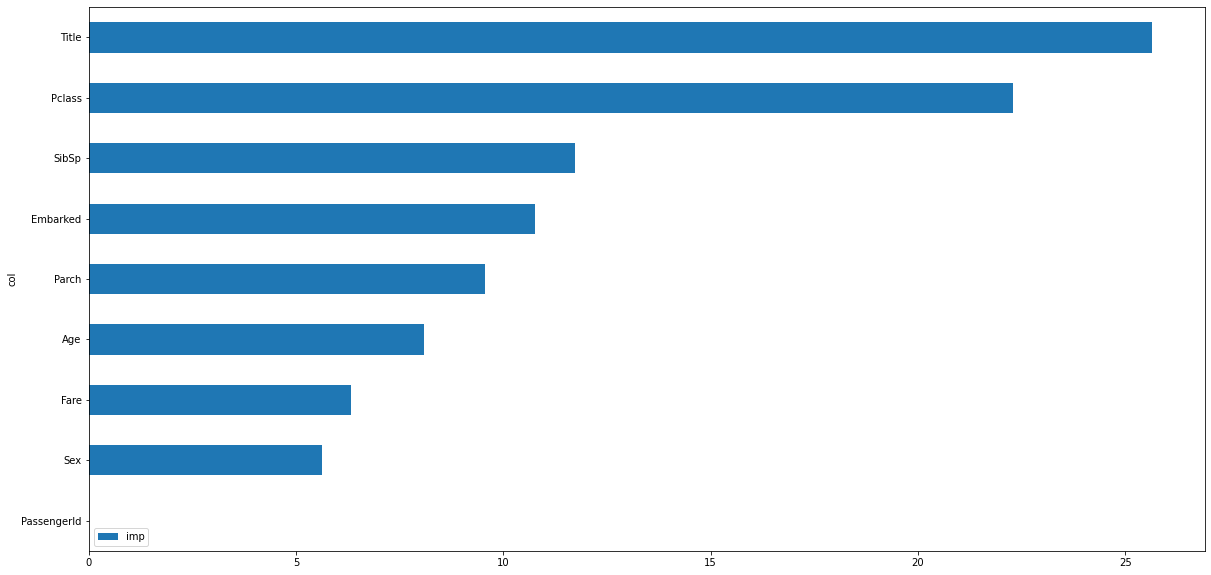

In [54]:
feature_importance(catboost_model, X_train)

In [55]:
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title'],
      dtype='object')

In [56]:
predictions = catboost_model.predict(test[wanted_test_columns])

In [57]:
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [58]:
submission['Survived'] = submission['Survived'].astype(int)

In [59]:
submission.to_csv('submission.csv', index=False)

In [60]:
submissions_check = pd.read_csv("submission.csv")
submissions_check.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
